In [1]:
'''
In this file we will load the bestfit models, create new halo catalog from them, and then will estimate the power spectrum. 
'''

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline

import matplotlib
import torch

dev = torch.device("cuda")
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
from torch.optim.lr_scheduler import ReduceLROnPlateau
# change the root directory for this notebook
root_dir = '/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/'
os.chdir(root_dir)

import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

ji = 0
ns_d = 256
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['cnn', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
z_all = [0, 0.5, 127]
ns_h = 128
nax_h = ns_h // nb

# nsims = 128



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
hidden_dim_MAF = 5
learning_rate = 0.01
K_M1 = 5
B_M1 = 3
nflows_M1_NSF = 5
K_Mdiff = 5
B_Mdiff = 3
nflows_Mdiff_NSF = 6
base_dist_M1 = 'gumbel'
base_dist_Mdiff = 'gumbel'
ngauss_M1 = 5
changelr = False
ksize = nf
nfeature_cnn = 4
nout_cnn = 4 * nfeature_cnn
ninp = len(z_all)
num_cond = nout_cnn + ninp
# nsims = 256
nsims_per_batch = 256
# nbatches_train = nb**3//nsims_per_batch
nbatches_train = 1


In [3]:
# Load the density data
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train = load_density_halo_data(
    ji, ns_d, nb, nf, nc, z_all, ns_h
    )

# Prepare the density and halo data
# return_dict_train = prep_density_halo_cats(
#     df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims
#     )
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train
    )




In [4]:
model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist=None
    )
# model_Ntot.to(dev)

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    mu_pos=False
    )

# model_M1.to(dev)

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'].shape[2]
ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 2,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )
# model_Mdiff.to(dev)

# print()



In [5]:
ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    )

model.to(dev)

print()



In [6]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20


cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all'])).cuda(dev)
# cond_tensor_nsh = torch.Tensor(np.copy(return_dict_train['df_d_all_nsh'].reshape(nsims * (nax_h ** 3), ninp))).cuda(dev)
cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
print(cond_nsh.shape)
cond_tensor_nsh = torch.Tensor(np.array(cond_nsh).reshape(nbatches_train,nsims_per_batch * (nax_h ** 3), ninp)).cuda(dev)
mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1']).reshape(nbatches_train,nsims_per_batch * (nax_h**3))).cuda(dev)
mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
                                                                                 ndim_diff))).cuda(dev)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1))).cuda(dev)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)).cuda(dev)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
                                                                                 ndim_diff)).cuda(dev)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)))).cuda(dev)






(256, 16, 16, 16, 3)


In [7]:
nsims_train = 256
save_bestfit_model_name = 'FINAL_COMBINED/model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nsh' + str(ns_h) + '_nsim' + str(nsims_train)

bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])



In [8]:
train_Ntot, train_M1, train_Mdiff = 1, 1, 1




In [9]:
# # cond_tensor = cond_tensor.to(dev)
# # cond_tensor_nsh = cond_tensor_nsh.to(dev)
# Ntot_samp_train, M1_samp_train, M_diff_samp_train, mask_tensor_M1_samp_train, mask_tensor_Mdiff_samp_train = model.inverse(
#         cond_x=cond_tensor,
#         cond_x_nsh=cond_tensor_nsh,
#         use_truth_Nhalo=False,
#             use_truth_M1=False,
#             use_truth_Mdiff=False,
#             mask_Mdiff_truth=mask_tensor_Mdiff_train,
#             mask_M1_truth=mask_tensor_M1_train,
#             Nhalos_truth=X_Nhalo,
#             M1_truth=X_M1,
#         train_Ntot=train_Ntot,
#         train_M1=train_M1,
#         train_Mdiff=train_Mdiff      
#         )






In [10]:
# cond_tensor_nsh.shape
# M1_samp_train.shape, X_M1.shape, mask_tensor_M1_train.shape
# Nhalos_truth_tensor.shape, Ntot_samp_train.shape


In [11]:
# delta_all_z0_train = np.exp(cond_tensor_nsh.cpu().detach().numpy()[:,0])-1
# # delta_min_p, delta_max_p = -1.0, -0.5
# # delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = 1.0, 2.0
# indsel_dp_train = np.where((delta_all_z0_train > delta_min_p) & (delta_all_z0_train < delta_max_p))[0]
# pl.figure()
# _ = pl.hist(Nhalos_truth_tensor.cpu().detach().numpy()[:,0][indsel_dp_train], histtype='step', bins=[0,1,2,3,4,5,6,7,8])
# _ = pl.hist(Ntot_samp_train[indsel_dp_train], bins=[0,1,2,3,4,5,6,7,8])
# pl.yscale('log')




In [12]:
# X_M1.shape


In [13]:
# delta_all_z0_test = np.exp(cond_tensor_nsh.cpu().detach().numpy()[:,0])-1
# # delta_min_p, delta_max_p = -1.0, -0.5
# # delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = 1.0, 2.0
# indsel_dp_test = np.where((delta_all_z0_test > delta_min_p) & (delta_all_z0_test < delta_max_p))[0]
# pl.figure()
# truth_val = (X_M1[:,0]*mask_tensor_M1_train).cpu().detach().numpy()[indsel_dp_test]
# _ = pl.hist(truth_val[truth_val > 0], histtype='step', range=(0,1))
# samp_val = M1_samp_train.cpu().detach().numpy()[indsel_dp_test]
# _ = pl.hist(samp_val[samp_val > 0], range=(0,1))
# pl.yscale('log')



In [14]:
# # now we load the test data
# nstart = 0
# nsims_test = 1
# df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data(
#     1, ns_d, nb, nf, nc, z_all, ns_h
#     )

# # things are too big to load all at once, so we load in batches
# nq = nb**3 // nsims_test
# save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
# save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
# save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
# save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
# mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
# nscount = 0
# from tqdm import tqdm
# for jq in tqdm(range(nq)):
# # for jq in tqdm(range(10)):    
#     # Load the density data


#     # Prepare the density and halo data
#     return_dict_test = prep_density_halo_cats(
#         df_d_all_test,
#         df_d_all_nsh_test,
#         df_Mh_all_test,
#         df_Nh_test,
#         nsims=nsims_test,
#         nstart=jq,
#         )

#     cond_tensor_test = torch.Tensor(np.copy(return_dict_test['df_d_all'])).cuda(dev)
#     cond_tensor_nsh_test = torch.Tensor(
#         np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
#         ).cuda(dev)
#     mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(nsims_test * (nax_h**3)))).cuda(dev)
#     mask_tensor_Mdiff_test = torch.Tensor(
#         (return_dict_test['mask_M_diff'].reshape(nsims_test * (nax_h**3), ndim_diff))
#         ).cuda(dev)

#     X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(nsims_test * (nax_h**3), 1))).cuda(dev)
#     X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(nsims_test * (nax_h**3), 1)).cuda(dev)
#     X_Mdiff_test = torch.Tensor(
#         return_dict_test['M_diff_halos_all_norm_masked'].reshape(nsims_test * (nax_h**3), ndim_diff)
#         ).cuda(dev)
#     Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(nsims_test * (nax_h**3),
#                                                                                       1)))).cuda(dev)

#     Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test = model.inverse(
#         cond_x=cond_tensor_test,
#         cond_x_nsh=cond_tensor_nsh_test,
#         use_truth_Nhalo=False,
#         use_truth_M1=False,
#         use_truth_Mdiff=False,
#         mask_Mdiff_truth=mask_tensor_Mdiff_test,
#         mask_M1_truth=mask_tensor_M1_test,
#         Nhalos_truth=X_Nhalo_test,
#         M1_truth=X_M1_test
#         )
#     # print(Ntot_samp_test.shape, cond_tensor_nsh_test.shape)
    
#     save_subvol_Nhalo[jq, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
#     save_subvol_Nhalo_truth[jq, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
#     save_subvol_M1[jq,
#                    ...] = (M1_samp_test * mask_tensor_M1_samp_test[:, 0]
#                           ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
#     save_subvol_Mdiff[jq,
#                       ...] = (M_diff_samp_test * mask_tensor_Mdiff_samp_test
#                              ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

#     mask_subvol_Mtot[jq, ...,
#                      0] = mask_tensor_M1_samp_test[:,
#                                                    0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
#     mask_subvol_Mtot[
#         jq, ...,
#         1:] = mask_tensor_Mdiff_samp_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
#     # print(Ntot_samp_tensor.shape)
#     # print(nscount, nscount + nsims_test)
#     # nscount += nsims_test
#     # pl.figure()
#     # pl.imshow(Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)[0,15,:,:])
#     # pl.scatter(cond_tensor_nsh_test.cpu().detach().numpy()[:,0], Ntot_samp_tensor.cpu().detach().numpy())
#     # pl.scatter(cond_tensor_nsh_test.cpu().detach().numpy()[:,0], Ntot_samp_test)    
#     # pl.scatter(cond_tensor_nsh_test.cpu().detach().numpy()[:,0], X_Nhalo_test.cpu().detach().numpy())    
#     # pl.scatter(Nhalos_truth_tensor_test.cpu().detach().numpy(), Ntot_samp_test)
#     # pl.scatter(cond_tensor_nsh_test.cpu().detach().numpy()[:,0], Nhalos_truth_tensor_test.cpu().detach().numpy())
#     # pl.imshow(Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)[0,8,:,:])
#     # _ = pl.hist(Ntot_samp_test.flatten(), histtype='step')
#     # print(np.sum(Ntot_samp_test))
#     # _ = pl.hist(Nhalos_truth_tensor_test.cpu().detach().numpy().flatten())    
#     # pl.yscale('log')
    
    
    

In [15]:
# nsims_test


In [16]:
# now we load the test data
nstart = 0
nsims_test = 64
df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data(
    1, ns_d, nb, nf, nc, z_all, ns_h
    )

# things are too big to load all at once, so we load in batches
nq = nb**3 // nsims_test
save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
nscount = 0
for jq in range(nq):
    # Load the density data


    # Prepare the density and halo data
    return_dict_test = prep_density_halo_cats(
        df_d_all_test,
        df_d_all_nsh_test,
        df_Mh_all_test,
        df_Nh_test,
        nsims=nsims_test,
        nstart=nscount,
        )

    cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
    cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
    cond_nsh_test = np.array([cond_nsh_test])
    # print(np.array([cond_nsh_test]).shape)
    cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
    # cond_tensor_nsh_test = torch.Tensor(
    #     np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
    #     ).cuda(dev)
    mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
    mask_tensor_Mdiff_test = torch.Tensor(
        (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
        ).cuda(dev)

    X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
    X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
    X_Mdiff_test = torch.Tensor(
        return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
        ).cuda(dev)
    Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                      1)))).cuda(dev)

    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test = model.inverse(
        cond_x=cond_tensor_test,
        cond_x_nsh=cond_tensor_nsh_test,
        use_truth_Nhalo=False,
        use_truth_M1=False,
        use_truth_Mdiff=False,
        mask_Mdiff_truth=mask_tensor_Mdiff_test,
        mask_M1_truth=mask_tensor_M1_test,
        Nhalos_truth=X_Nhalo_test,
        M1_truth=X_M1_test,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff         
        )
    Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
    # print(Ntot_samp_test.shape)
    save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_M1[nscount:nscount + nsims_test,
                   ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]
                          ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
    save_subvol_Mdiff[nscount:nscount + nsims_test,
                      ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                             ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

    mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                     0] = mask_tensor_M1_samp_test[0][:,
                                                   0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    mask_subvol_Mtot[
        nscount:nscount + nsims_test, ...,
        1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
    # print(nscount, nscount + nsims_test)
    

    
    # delta_all_z0_test = np.exp(cond_tensor_nsh_test.cpu().detach().numpy()[:,0])-1
    # # delta_min_p, delta_max_p = -1.0, -0.5
    # # delta_min_p, delta_max_p = -0.5, -0.0
    # delta_min_p, delta_max_p = 1.0, 2.0
    # indsel_dp_test = np.where((delta_all_z0_test > delta_min_p) & (delta_all_z0_test < delta_max_p))[0]
    # pl.figure()
    # _ = pl.hist(Nhalos_truth_tensor_test.cpu().detach().numpy()[:,0][indsel_dp_test], histtype='step', bins=[0,1,2,3,4,5,6,7,8])
    # _ = pl.hist(Ntot_samp_test[indsel_dp_test], bins=[0,1,2,3,4,5,6,7,8])
    # pl.yscale('log')
    
#     print(Nhalos_truth_tensor_test.shape, Ntot_samp_test.shape)
    
#     # delta_all_z0_test = np.exp(cond_tensor_nsh_test.cpu().detach().numpy()[:,0].reshape(nsims_test, nax_h, nax_h, nax_h)) - 1
#     delta_all_z0_test = np.exp(cond_z0_truth[nscount:nscount + nsims_test, ...]) - 1
#     # delta_min_p, delta_max_p = -1.0, -0.5
#     # delta_min_p, delta_max_p = -0.5, -0.0
#     delta_min_p, delta_max_p = 1.0, 2.0
#     indsel_dp_test = np.where((delta_all_z0_test > delta_min_p) & (delta_all_z0_test < delta_max_p))
#     pl.figure()
#     _ = pl.hist(Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)[indsel_dp_test], histtype='step', bins=[0,1,2,3,4,5,6,7,8])
#     _ = pl.hist(Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)[indsel_dp_test], bins=[0,1,2,3,4,5,6,7,8])
#     pl.yscale('log')
#     pl.ylim(1,3e4)
    
    # delta_all_z0_test1 = np.exp(cond_tensor_nsh_test.cpu().detach().numpy()[:,0].reshape(nsims_test, nax_h, nax_h, nax_h)) - 1
    # delta_all_z0_test2 = np.exp(cond_z0_truth[nscount:nscount + nsims_test, ...]) - 1
    # print(delta_all_z0_test1.shape, delta_all_z0_test2.shape)
    # pl.figure()
    # _ = pl.hist(delta_all_z0_test1.flatten(), histtype='step', range=(-1,30))
    # _ = pl.hist(delta_all_z0_test2.flatten(), range=(-1,30))
    # pl.yscale('log')
    # pl.ylim(1,3e4)
    
    

    # delta_all_z0_test = np.exp(cond_tensor_nsh_test.cpu().detach().numpy()[:,0])-1
    # # delta_min_p, delta_max_p = -1.0, -0.5
    # # delta_min_p, delta_max_p = -0.5, -0.0
    # delta_min_p, delta_max_p = 1.0, 2.0
    # indsel_dp_test = np.where((delta_all_z0_test > delta_min_p) & (delta_all_z0_test < delta_max_p))[0]
    # pl.figure()
    # truth_val = (X_M1_test[:,0]*mask_tensor_M1_test).cpu().detach().numpy()[indsel_dp_test]
    # _ = pl.hist(truth_val[truth_val > 0], histtype='step', range=(0,1))
    # samp_val = M1_samp_test.cpu().detach().numpy()[indsel_dp_test]
    # _ = pl.hist(samp_val[samp_val > 0], range=(0,1))
    # pl.yscale('log')

    nscount += nsims_test
    
    
    

0 64
64 128
128 192
192 256
256 320
320 384
384 448
448 512


In [17]:
# delta_all_z0_test1 = np.exp(cond_tensor_nsh_test.cpu().detach().numpy()[:,0].reshape(nsims_test, nax_h, nax_h, nax_h)) - 1
# delta_all_z0_test2 = np.exp(cond_z0_truth[:-nsims_test, ...]) - 1
# print(delta_all_z0_test1.shape, delta_all_z0_test2.shape)
# pl.figure()
# _ = pl.hist(delta_all_z0_test1.flatten(), histtype='step', range=(-1,30))
# _ = pl.hist(delta_all_z0_test2.flatten(), range=(-1,30))
# pl.yscale('log')



In [18]:
# save_subvol_Nhalo
# df_Nh_test.shape, save_subvol_Nhalo.shape
# Ntot_samp_test
# cond_tensor_nsh_test.shape
# cond_z0_truth.shape, df_d_all_nsh_test[:,0,...].shape
# df_d_all_nsh_test_rs = df_d_all_nsh_test.reshape(nb**3 * nax_h**3, ninp)
# df_d_all_nsh_test_rs_rs = df_d_all_nsh_test_rs.reshape(nb**3, ninp, nax_h, nax_h, nax_h)
save_subvol_Nhalo_truth.shape, df_Nh_test.shape, save_subvol_Nhalo.shape



((512, 16, 16, 16), (512, 16, 16, 16), (512, 16, 16, 16))

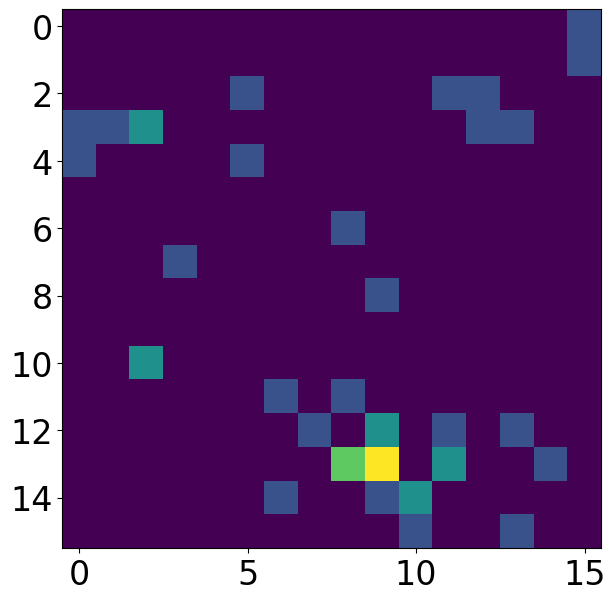

In [19]:
# cond_z0_truth
pl.figure()
pl.imshow(save_subvol_Nhalo_truth[128,10,:,:])


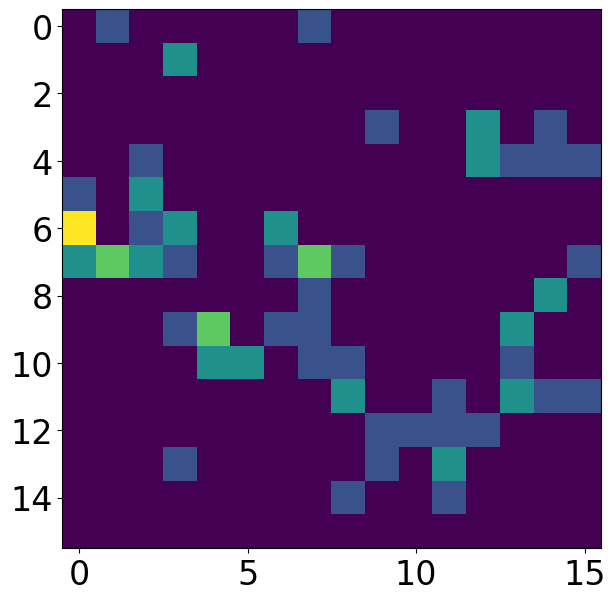

In [20]:
# cond_z0_truth
indsim = 300
pl.figure()
pl.imshow(df_Nh_test[indsim,10,:,:])




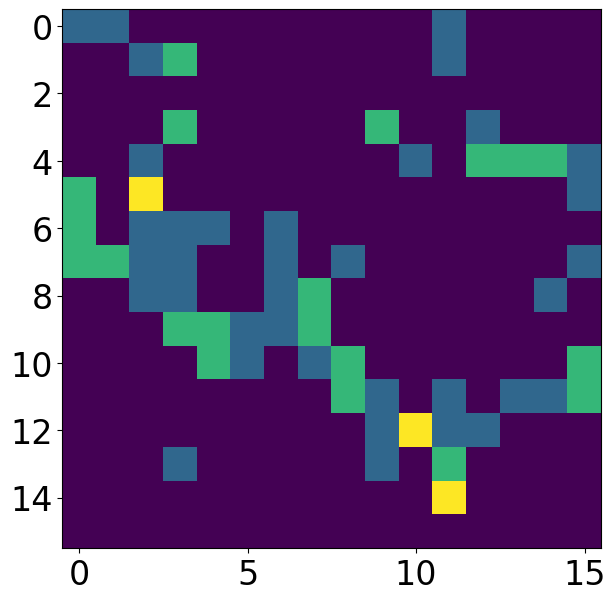

In [21]:
# cond_z0_truth
pl.figure()
pl.imshow(save_subvol_Nhalo[indsim,10,:,:])




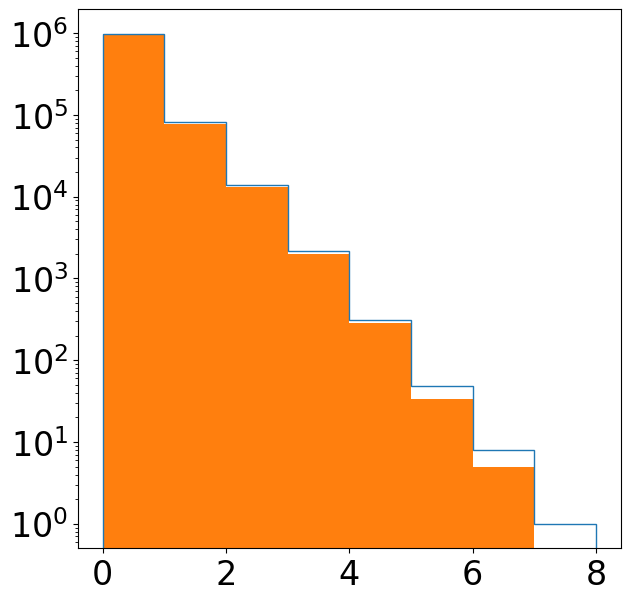

In [22]:
# cond_z0_truth.shape
indsel = np.where((cond_z0_truth > -1.0) & (cond_z0_truth < 0.0))
# cond_z0_truth
pl.figure()
_ = pl.hist(save_subvol_Nhalo[indsel], histtype='step', bins=[0,1,2,3,4,5,6,7,8])
_ = pl.hist(df_Nh_test[indsel], bins=[0,1,2,3,4,5,6,7,8])
pl.yscale('log')




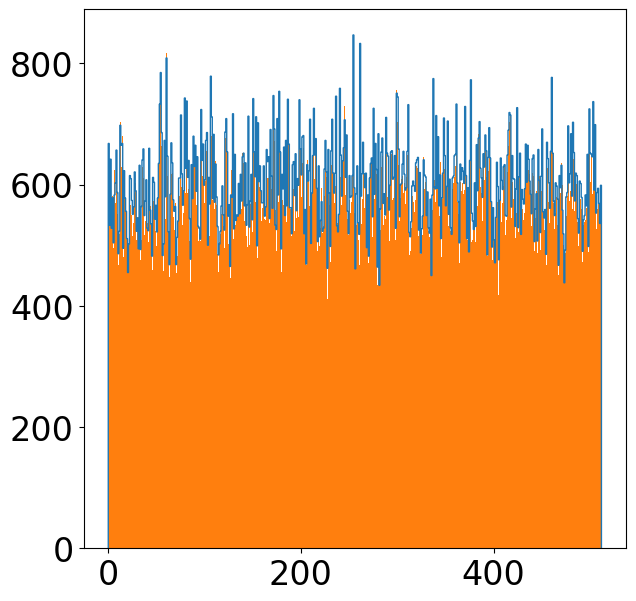

In [23]:
# pl.figure()
# pl.imshow((save_subvol_Nhalo[60,8,:,:]))
# # save_subvol_Nhalo.shape
# # subvol_size
# np.where(save_subvol_Nhalo > 0)[0]
pl.figure()
_ = pl.hist(np.where(save_subvol_Nhalo > 0)[0], range=(0,512), bins=512, histtype='step')
_ = pl.hist(np.where(save_subvol_Nhalo_truth > 0)[0], range=(0,512), bins=512)
# pl.yscale('log')
# _ = pl.hist(np.where(df_Nh_test > 0)[0], bins=50)



In [24]:
# nstart = 100
# nsims_test = 9
# return_dict_test = prep_density_halo_cats(
#     df_d_all_test,
#     df_d_all_nsh_test,
#     df_Mh_all_test,
#     df_Nh_test,
#     nsims=nsims_test,
#     nstart=nstart,
#     )

# cond_tensor_test = torch.Tensor(np.copy(return_dict_test['df_d_all'])).cuda(dev)
# cond_tensor_nsh_test = torch.Tensor(
#     np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
#     ).cuda(dev)
# mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(nsims_test * (nax_h**3)))).cuda(dev)
# mask_tensor_Mdiff_test = torch.Tensor(
#     (return_dict_test['mask_M_diff'].reshape(nsims_test * (nax_h**3), ndim_diff))
#     ).cuda(dev)

# X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(nsims_test * (nax_h**3), 1))).cuda(dev)
# X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(nsims_test * (nax_h**3), 1)).cuda(dev)
# X_Mdiff_test = torch.Tensor(
#     return_dict_test['M_diff_halos_all_norm_masked'].reshape(nsims_test * (nax_h**3), ndim_diff)
#     ).cuda(dev)
# Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(nsims_test * (nax_h**3),
#                                                                                   1)))).cuda(dev)

# Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test = model.inverse(
#     cond_x=cond_tensor_test,
#     cond_x_nsh=cond_tensor_nsh_test,
#     use_truth_Nhalo=False,
#     use_truth_M1=False,
#     use_truth_Mdiff=False,
#     mask_Mdiff_truth=mask_tensor_Mdiff_test,
#     mask_M1_truth=mask_tensor_M1_test,
#     Nhalos_truth=X_Nhalo_test,
#     M1_truth=X_M1_test
#     )
# # print(Ntot_samp_test.shape)
# # save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
# # save_subvol_M1[nscount:nscount + nsims_test,
# #                ...] = (M1_samp_test * mask_tensor_M1_samp_test[:, 0]
# #                       ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
# # save_subvol_Mdiff[nscount:nscount + nsims_test,
# #                   ...] = (M_diff_samp_test * mask_tensor_Mdiff_samp_test
# #                          ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

# # mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
# #                  0] = mask_tensor_M1_samp_test[:,
# #                                                0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
# # mask_subvol_Mtot[
# #     nscount:nscount + nsims_test, ...,
# #     1:] = mask_tensor_Mdiff_samp_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
# # print(nscount)
# # nscount += nsims_test


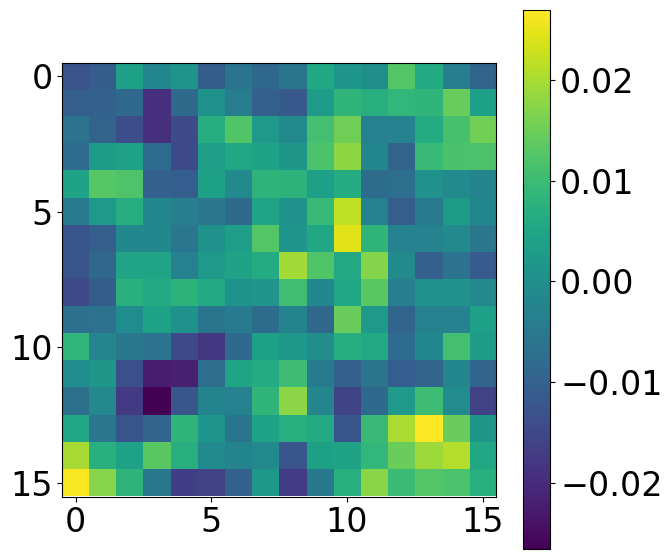

In [25]:
# Ntot_samp_test_rs = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
# cond_tensor_nsh_test.shape
cond_tensor_nsh_test_rs = cond_tensor_nsh_test.reshape(nsims_test, nax_h, nax_h, nax_h, ninp).cpu().detach().numpy()
pl.figure()
pl.imshow(cond_tensor_nsh_test_rs[0,8,...,2])
pl.colorbar()



In [26]:
cond_tensor_nsh_test.shape


torch.Size([262144, 3])

In [27]:
# cond_tensor_nsh_test.shape
# Ntot_samp_test.shape
# np.any(Ntot_samp_test > 0)
# np.amax(Ntot_samp_test)
# Ntot_samp_test.reshape(


In [28]:
# # Ntot_samp_test_rs[0,...].flatten()
# pl.figure()
# _ = pl.hist(Ntot_samp_test_rs[8,...].flatten())


In [29]:
save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0]) * (Mmax - Mmin) + Mmin
    else:
        save_subvol_Mtot[...,
                         jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)




        

In [30]:
# return_dict_test = prep_density_halo_cats(
#         df_d_all_test,
#         df_d_all_nsh_test,
#         df_Mh_all_test,
#         df_Nh_test,
#         nsims=128,
#         nstart=0,
#         )




In [31]:
# Nhalo_rs = return_dict_test['N_halos_all'].reshape(nsims_test * (nax_h**3),1)
# Nhalo_rs_rs = Nhalo_rs.reshape(nsims_test, nax_h**3)
# Nhalo_rs_rs.shape, return_dict_test['N_halos_all'].shape


In [32]:
# # return_dict_test['N_halos_all'].shape
# pl.figure()
# # _ = pl.hist(return_dict_test['N_halos_all'][100])
# # _ = pl.hist(Nhalo_rs_rs[100])
# _ = pl.hist(Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)[100,...].flatten())
# _ = pl.hist(save_subvol_Nhalo[100,...].flatten(), histtype='step')
# pl.yscale('log')




In [33]:
save_subvol_Mtot *= mask_subvol_Mtot


In [34]:
ind_less_Mmin = save_subvol_Mtot < Mmin
ind_greater_Mmax = save_subvol_Mtot > Mmax
save_subvol_Mtot[ind_less_Mmin] = 0.0
save_subvol_Mtot[ind_greater_Mmax] = 0.0



In [35]:
# np.amax(save_subvol_Mtot[...,0])
save_subvol_Mtot.shape



(512, 16, 16, 16, 10)

In [36]:
sdir='/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density'
# load the halo data
fname = sdir + '/' + str(1) + '/halo_data_dict_' + str(ns_h) + '.pk'
df_h = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h['N_halos']

df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']



In [37]:
df_Mh_all_truth.shape, df_Nh_truth.shape, df_Mh_all_truth_comb.shape, df_Nh_truth_comb.shape


((512, 16, 16, 16, 10),
 (512, 16, 16, 16),
 (128, 128, 128, 10),
 (128, 128, 128))

In [38]:
# create empty arrays for Nhalos and M_halos
Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

subvol_size = ns_h // nb

ind_cart_lin = {}
ind_lin_cart = {}
jc = 0
from tqdm import tqdm
for jx in tqdm(range(nb)):
    for jy in range(nb):
        for jz in range(nb):
            # get the sub-cube
            ind_lin_cart[(jx, jy, jz)] = jc
            ind_cart_lin[jc] = [jx, jy, jz]
            jc += 1
            

# iterate over subvolumes
jc = 0
for jx in range(nb):
    for jy in range(nb):
        for jz in range(nb):
            # update Nhalos and M_halos with subvolumes
#             Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[jc]

#             M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                     jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[jc]

            Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                   jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

            M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
            
            
            jc += 1
            
            
            


100%|██████████| 8/8 [00:00<00:00, 6266.00it/s]


In [39]:
# # df_d_all_nsh_test.shape, df_Nh_truth.shape
# # df_Nh_truth.shape
# delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# # delta_min_p, delta_max_p = -1.0, -0.5
# # delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = 1.0, 2.0
# indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
# pl.figure()
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8])
# _ = pl.hist(df_Nh_test[indsel_dp].flatten(), bins=[0,1,2,3,4,5,6,7,8])
# pl.yscale('log')




Text(0.5, 1.0, '3.0$< \\delta_m < $10.0')

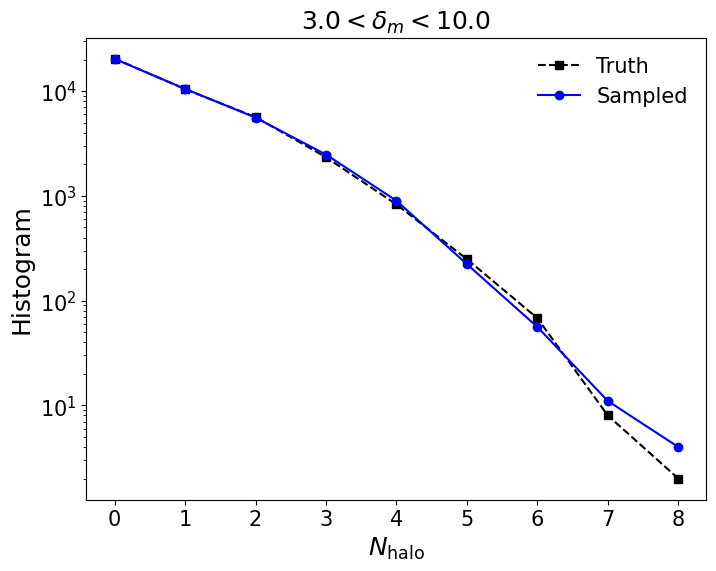

In [40]:
delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# delta_min_p, delta_max_p = -1.0, -0.5
# delta_min_p, delta_max_p = -0.5, -0.0
delta_min_p, delta_max_p = 3.0, 10.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.array([0,1,2,3,4,5,6,7,8])
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
hist_truth, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
hist_samp, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$N_{\rm halo}$', size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)



Text(0.5, 1.0, '1.0$< \\delta_m < $3.0')

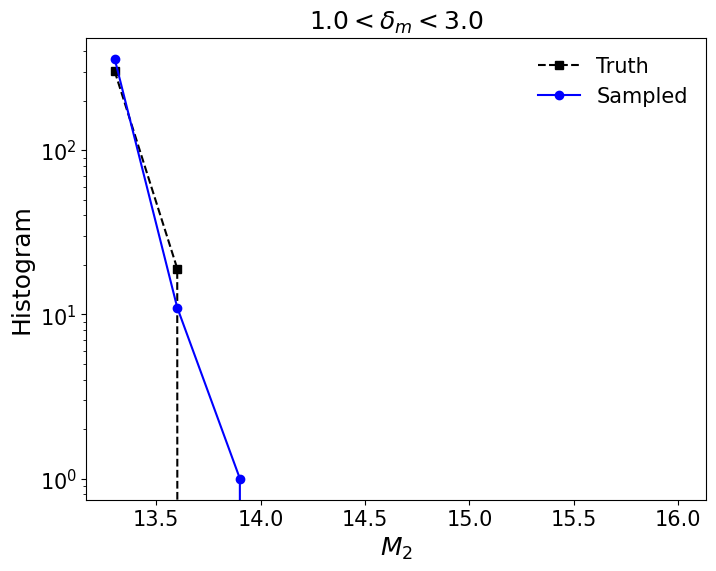

In [41]:
delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# delta_min_p, delta_max_p = -1.0, -0.5
# delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = -1.0, 0.0
# delta_min_p, delta_max_p = 0.0, 1.0
delta_min_p, delta_max_p = 1.0, 3.0
# delta_min_p, delta_max_p = 3.0, 10.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.linspace(13.3, 16.0, 10)
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
delta_b = 0.5*(bin_cents[1] - bin_cents[0])
bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

idim = 4
M_idim_truth = df_Mh_all_truth[..., idim]

hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')

M_idim_samp = save_subvol_Mtot[..., idim]
hist_samp, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$M_2$', size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)



In [42]:
df_Mh_all_truth.shape, save_subvol_Mtot.shape



((512, 16, 16, 16, 10), (512, 16, 16, 16, 10))

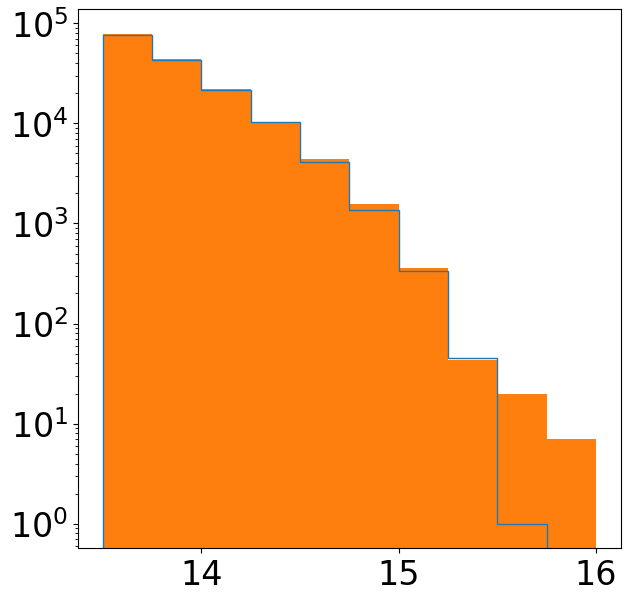

In [43]:
indM = 3
pl.figure()
_ = pl.hist(df_Mh_all_truth[...].flatten(), histtype='step', range=(13.5,16))
_ = pl.hist(save_subvol_Mtot[...].flatten(), range=(13.5,16))
pl.yscale('log')
# 




In [44]:
# save_subvol_Nhalo.shape
# Nhalos = save_subvol_Nhalo.reshape(ns_h, ns_h, ns_h)
# M_halos = save_subvol_Mtot.reshape(ns_h, ns_h, ns_h, ndim_diff + 1)



In [45]:
# create empty arrays for Nhalos and M_halos
Nhalos = np.zeros((ns_h, ns_h, ns_h))
M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

subvol_size = ns_h // nb

ind_cart_lin = {}
ind_lin_cart = {}
jc = 0
from tqdm import tqdm
for jx in tqdm(range(nb)):
    for jy in range(nb):
        for jz in range(nb):
            # get the sub-cube
            ind_lin_cart[(jx, jy, jz)] = jc
            ind_cart_lin[jc] = [jx, jy, jz]
            jc += 1
            

# iterate over subvolumes
jc = 0
for jx in range(nb):
    for jy in range(nb):
        for jz in range(nb):
            # update Nhalos and M_halos with subvolumes
#             Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[jc]

#             M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                     jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[jc]

            Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                   jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

            M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
            
            
            jc += 1
            
            
            

100%|██████████| 8/8 [00:00<00:00, 43129.09it/s]


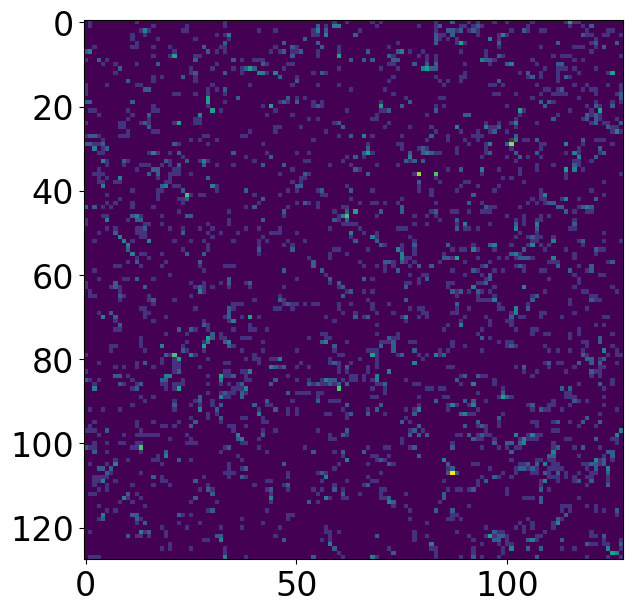

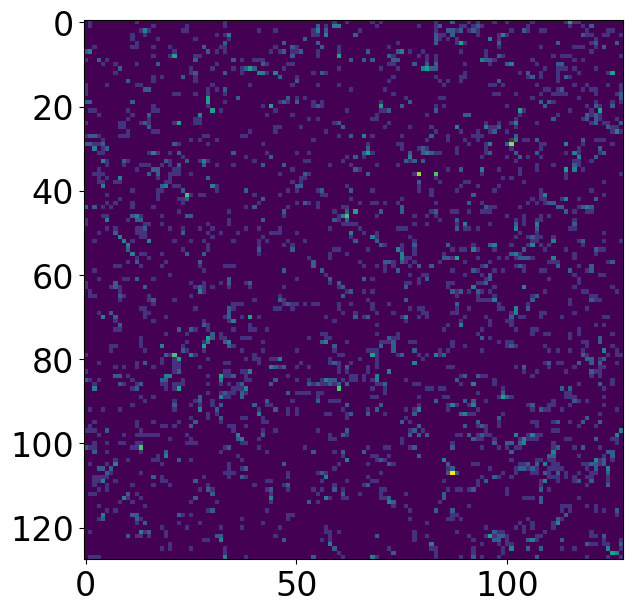

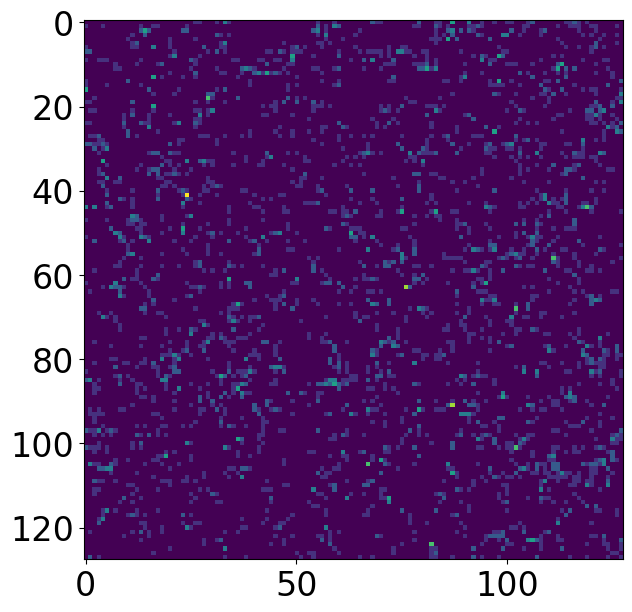

In [46]:
# Nhalos_truth_recomb.shape
pl.figure()
pl.imshow(Nhalos_truth_recomb[64,...])
# Nhalos_truth_recomb.shape
pl.figure()
pl.imshow(df_Nh_truth_comb[64,...])
pl.figure()
pl.imshow(Nhalos[64,...])



            

In [ ]:
# Nhalos_truth_recomb.shape
pl.figure()
pl.imshow(M_halos_truth_recomb[64,:,:,0], vmin=13, vmax=16, origin='lower')
pl.figure()
pl.imshow(M_halos[64,:,:,0], vmin=13, vmax=16, origin='lower')



            

In [ ]:
# pl.imshow(df_Nh_truth_comb[64,...])
# pl.figure()
# pl.imshow(Nhalos[64,...])
# # 
pl.figure()
# pl.scatter(df_Nh_truth_comb[64,...].flatten(), Nhalos[64,...].flatten(), s=0.1)
pl.scatter(M_halos[64,:,:,0].flatten(), M_halos_truth_recomb[64,:,:,0].flatten(), s=0.3)
pl.xlim(12,16)
pl.ylim(12,16)




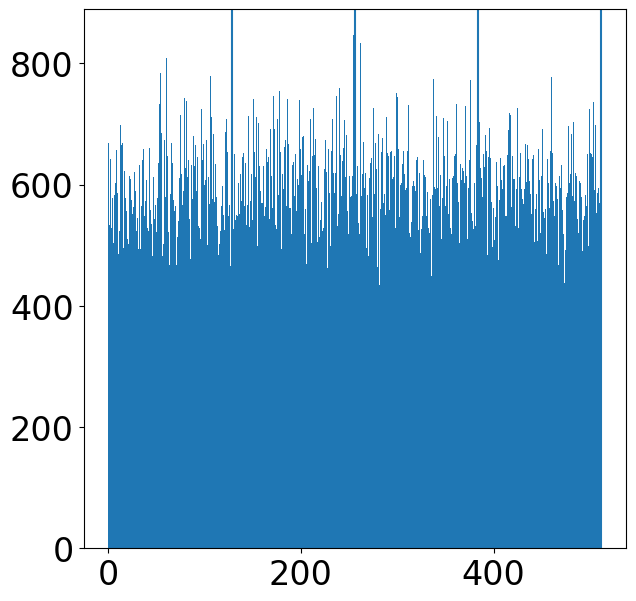

In [47]:
# pl.figure()
# pl.imshow((save_subvol_Nhalo[60,8,:,:]))
# # save_subvol_Nhalo.shape
# # subvol_size
# np.where(save_subvol_Nhalo > 0)[0]
pl.figure()
_ = pl.hist(np.where(save_subvol_Nhalo > 0)[0], range=(0,512),  bins=512)
pl.axvline(128)
pl.axvline(256)
pl.axvline(384)
pl.axvline(512)
# _ = pl.hist(np.where(df_Nh_test > 0)[0], bins=50)


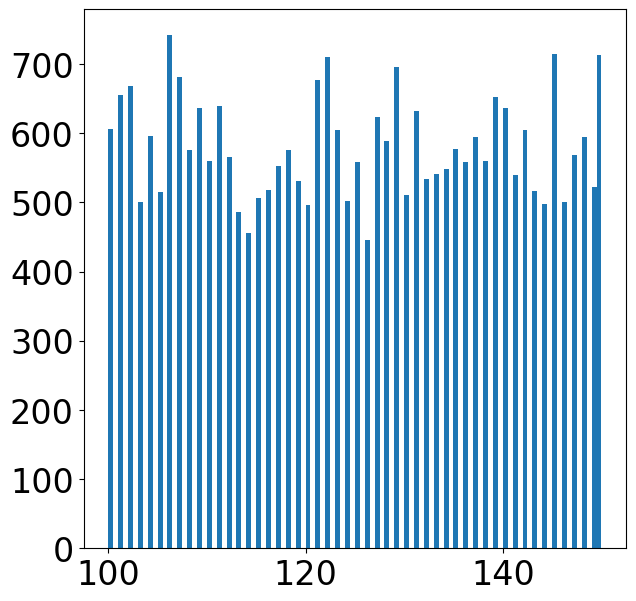

In [48]:
pl.figure()
_ = pl.hist(np.where(df_Nh_test > 0)[0], range=(100,150), bins=100)



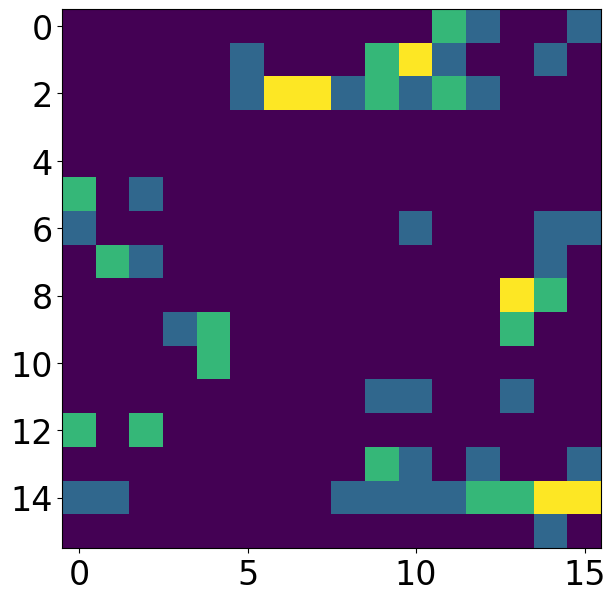

In [49]:
pl.figure()
pl.imshow(save_subvol_Nhalo[109,8,:,:])




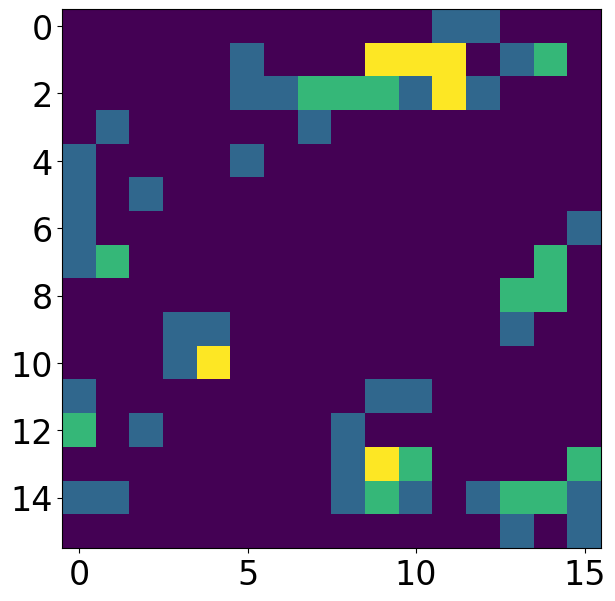

In [50]:
pl.figure()
pl.imshow(save_subvol_Nhalo_truth[109,8,:,:])




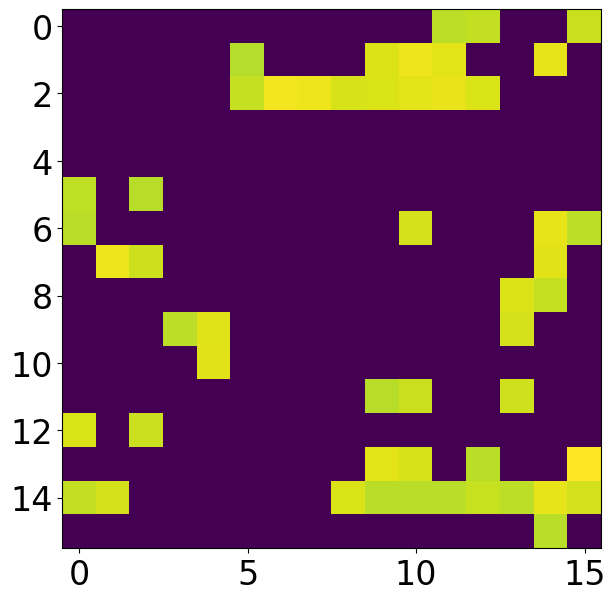

In [51]:
# save_subvol_Nhalo[109,15,:,:]
# save_subvol_Mtot[109,15,:,:,0]
pl.figure()
pl.imshow(save_subvol_Mtot[109,8,:,:,0])




In [52]:
# df_Nh_truth.shape


In [53]:
# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')




In [54]:
# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
dx = (xall[1] - xall[0])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(Nhalos[jx, jy, jz])
                if Nh_vox > 0:
                    # for jh in range(Nh_vox):
                    # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))

# convert to numpy arrays
x_h_mock = np.concatenate(x_h_mock)
y_h_mock = np.concatenate(y_h_mock)
z_h_mock = np.concatenate(z_h_mock)
pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
lgMass_mock = np.concatenate(lgM_mock)
# convert to float data type
pos_h_mock = pos_h_mock.astype('float32')
lgMass_mock = lgMass_mock.astype('float32')

import numpy as np
import h5py as h5
with h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/mock_halo_ns' + str(ns_h) + '.h5', 'w') as f:
    # create a new dataset and write the data to it
    f.create_dataset('x_h', data=x_h_mock)
    f.create_dataset('y_h', data=y_h_mock)
    f.create_dataset('z_h', data=z_h_mock)
    f.create_dataset('lgMass_mock', data=lgMass_mock)    
    f.close()

    


In [55]:
# df_Nh_truth_comb.shape
# ns_h


In [56]:
sdir='/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density'
# load the halo data
fname = sdir + '/' + str(1) + '/halo_data_dict_' + str(ns_h) + '.pk'
df_h = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h['N_halos']

df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']
# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
dx = (xall[1] - xall[0])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
                if Nh_vox > 0:
                    # for jh in range(Nh_vox):
                    # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

# convert to numpy arrays
x_h_truth = np.concatenate(x_h_truth)
y_h_truth = np.concatenate(y_h_truth)
z_h_truth = np.concatenate(z_h_truth)
pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
lgMass_truth = np.concatenate(lgM_truth)
# convert to float data type
pos_h_truth = pos_h_truth.astype('float32')
lgMass_truth = lgMass_truth.astype('float32')

import numpy as np
import h5py as h5
with h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/truth_halo_ns' + str(ns_h) + '.h5', 'w') as f:
    # create a new dataset and write the data to it
    f.create_dataset('x_h', data=x_h_truth)
    f.create_dataset('y_h', data=y_h_truth)
    f.create_dataset('z_h', data=z_h_truth)
    f.create_dataset('lgMass_mock', data=lgMass_truth)    
    f.close()

    




In [57]:
# import MAS_library as MASL
import sys, os
from tqdm import tqdm
import readfof
import numpy as np
import pickle as pk 
from nbodykit.lab import *
import h5py as h5




In [58]:
# %pip install --upgrade astropy


In [59]:
import readfof
import MAS_library as MASL
snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
# load the corresponding halo catalogue
snapdir = snap_dir_base + '/' + str(1)  #folder hosting the catalogue
snapnum=4
# determine the redshift of the catalogue
# z_dict = {4: 0.0, 3: 0.5, 2: 1.0, 1: 2.0, 0: 3.0}
# redshift = z_dict[snapnum]

# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

lgMass_truth = np.log10(mass_truth)

Mmin_Pk, Mmax_Pk = 14.5, 15.0
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
print(len(indsel_Pk_truth))
# density field parameters
grid    = ns_h    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress

df_nbkit = {}
# lgM_samp = df_samp['lgM_samp_all_f']
# df_nbkit['Position'] = np.vstack((df_samp['x_samp_all'], df_samp['y_samp_all'], df_samp['z_samp_all'])).T
df_nbkit['Position'] = pos_h_truth[indsel_Pk_truth,...]
# np.vstack((df_samp['x_samp_all'], df_samp['y_samp_all'], df_samp['z_samp_all'])).T.shape
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
mesh_truth = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
r = FFTPower(mesh_truth, mode='1d', dk=0.05)
Pk_truth = r.power



5500


/tmp/ipykernel_66293/1317811656.py:36: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_truth = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')


In [60]:
import numpy as np
import h5py as h5
df = h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/truth_halo_ns256.h5', 'r')
pos_h_truth = np.vstack((df['x_h'][()],df['y_h'][()],df['z_h'][()])).T
lgMass_truth = df['lgMass_mock'][()]
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
df_nbkit = {}
df_nbkit['Position'] = pos_h_truth[indsel_Pk_truth,...]
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
mesh_truth2 = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
r = FFTPower(mesh_truth2, mode='1d', dk=0.05)
Pk_truth2 = r.power



/tmp/ipykernel_66293/1010657548.py:11: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_truth2 = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')


In [61]:
import numpy as np
import h5py as h5
df = h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/mock_halo_ns256.h5', 'r')
pos_h_mock = np.vstack((df['x_h'][()],df['y_h'][()],df['z_h'][()])).T
lgMass_mock = df['lgMass_mock'][()]


indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
df_nbkit = {}
df_nbkit['Position'] = pos_h_mock[indsel_Pk_mock,...]
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
mesh_mock = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
r = FFTPower(mesh_mock, mode='1d', dk=0.05)
Pk_mock = r.power





/tmp/ipykernel_66293/1455136678.py:13: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')


In [62]:
r = FFTPower(mesh_truth, second=mesh_mock, mode='1d', dk=0.05)
Pk_mockxtruth = r.power 



In [63]:
# r = FFTPower(mesh_truth2, second=mesh_mock, mode='1d', dk=0.05)
# Pk_mockxtruth2 = r.power
r = FFTPower(mesh_mock, second=mesh_truth2, mode='1d', dk=0.05)
Pk_mockxtruth2 = r.power



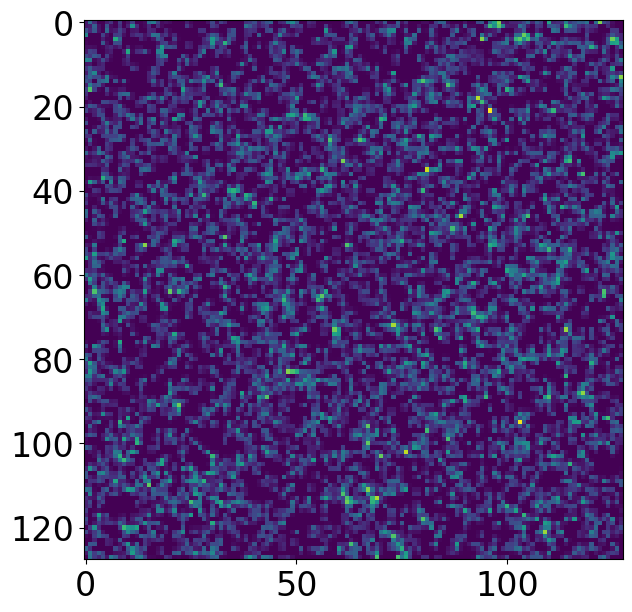

In [64]:
# mesh.shape
pl.imshow(((mesh_truth.preview(axes=[0,1]))))
# pl.savefig('from_MAF.pdf')




Text(0.5, 1.0, 'AR-NPE')

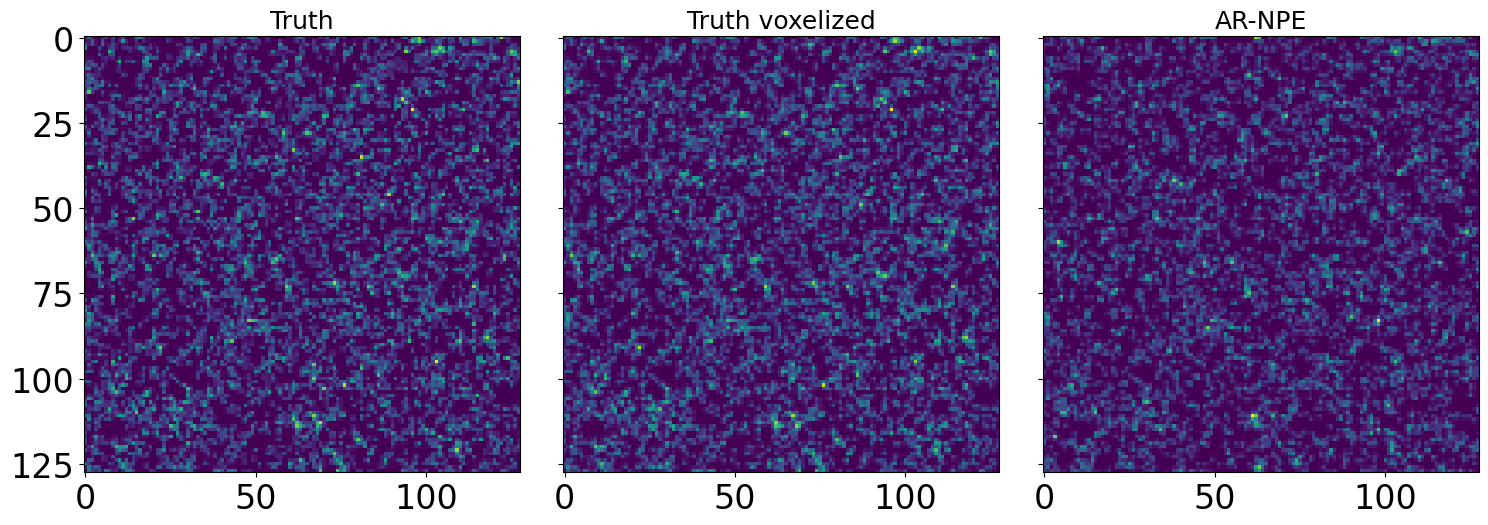

In [71]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
axes[0].set_title('Truth', size=18)
axes[1].imshow(((mesh_truth2.preview(axes=[0,1]))))
axes[1].set_title('Truth voxelized', size=18)
axes[2].imshow(((mesh_mock.preview(axes=[0,1]))))
axes[2].set_title('AR-NPE', size=18)





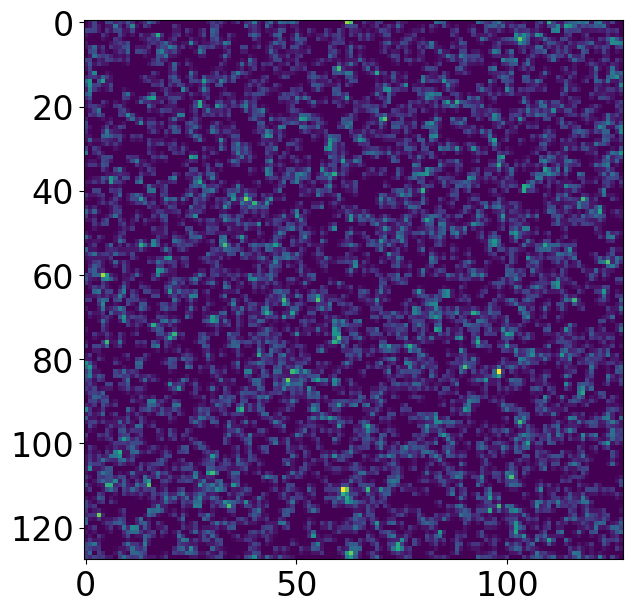

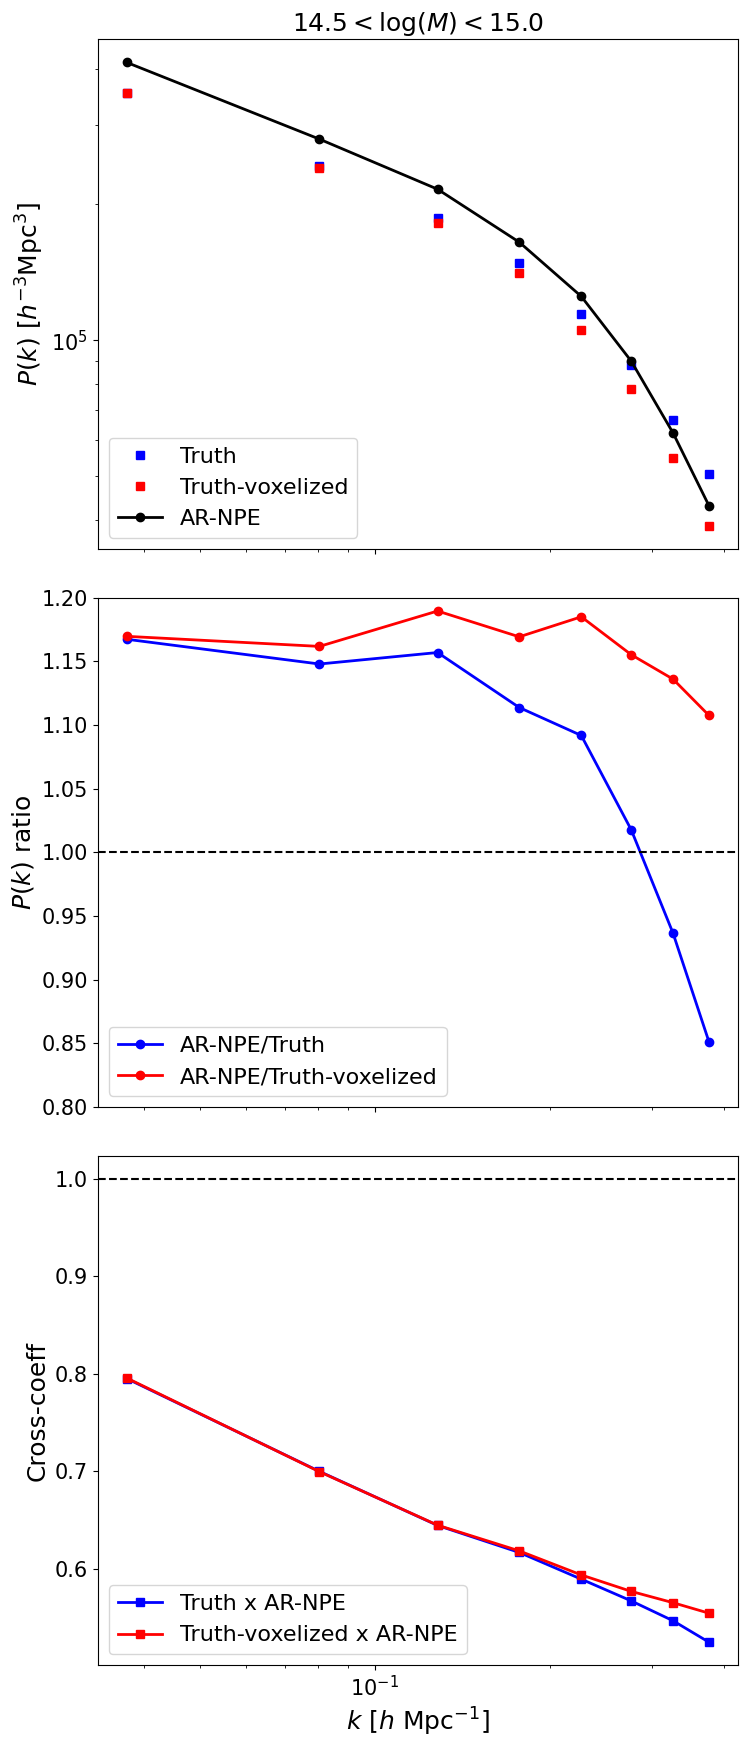

In [76]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
# First subplot
axes[0].loglog(Pk_truth['k'], Pk_truth['power'].real, label='Truth', color='b', ls='', marker='s', lw=2.0)
axes[0].loglog(Pk_truth2['k'], Pk_truth2['power'].real, label='Truth-voxelized', color='r', ls='', marker='s', lw=2.0)
axes[0].loglog(Pk_mock['k'], (Pk_mock['power'].real), label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)
axes[0].legend(fontsize=16, loc='lower left')
# axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]", size=18)
axes[0].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=18)
axes[0].tick_params(axis='both', labelsize=15)
# Second subplot
axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real) / Pk_truth['power'].real, label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real) / Pk_truth2['power'].real, label='AR-NPE/Truth-voxelized', color='r', ls='-', marker='o', lw=2.0)
axes[1].legend(fontsize=16, loc='lower left')
# axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[1].set_ylabel(r"$P(k)$ ratio", size=18)
axes[1].axhline(1.0, ls='--', color='k')
axes[1].set_ylim(0.8, 1.2)
axes[1].tick_params(axis='both', labelsize=15)
# axes[1].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=20)

# Third subplot
axes[2].plot(Pk_mockxtruth['k'], (Pk_mockxtruth['power'].real) / (((Pk_mock['power'].real) * (Pk_truth['power'].real)) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
axes[2].plot(Pk_mockxtruth2['k'], (Pk_mockxtruth2['power'].real) / (((Pk_mock['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='-', marker='s', lw=2.0)
axes[2].axhline(1.0, ls='--', color='k')
axes[2].set_xscale('log')
axes[2].legend(fontsize=16)
axes[2].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[2].set_ylabel(r"Cross-coeff", size=18)
axes[2].tick_params(axis='both', labelsize=15)
plt.tight_layout()
plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 

                   

In [147]:
# pl.figure()
# pl.imshow(delta_mock[32,:,:])
# np.pi/4.


In [149]:
# pl.figure()
# pl.imshow(delta_truth[32,:,:])


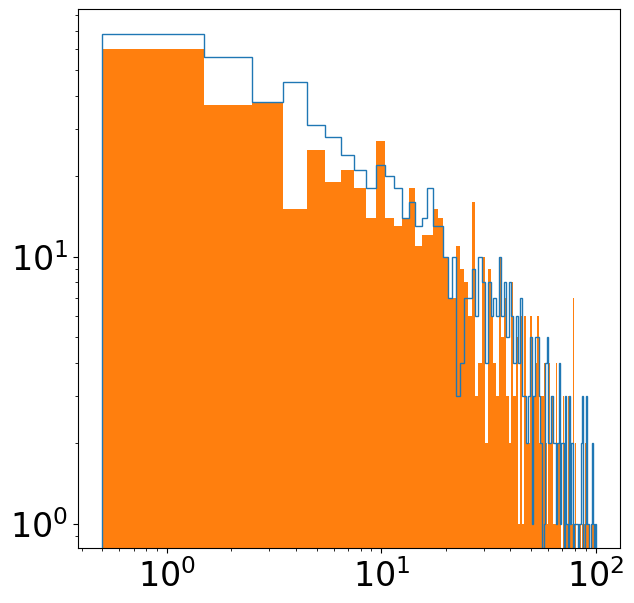

In [60]:
pl.figure()
# pl.scatter(delta_mock[64,:,:].flatten(), delta_truth[64,:,:].flatten())
_ = pl.hist(1+delta_mock[64,:,:].flatten(), bins=100, histtype='step', range=(0.5,100))
_ = pl.hist(1+delta_truth[64,:,:].flatten(), bins=100, range=(0.5,100))
pl.yscale('log')
pl.xscale('log')
           

(30000.0, 500000.0)

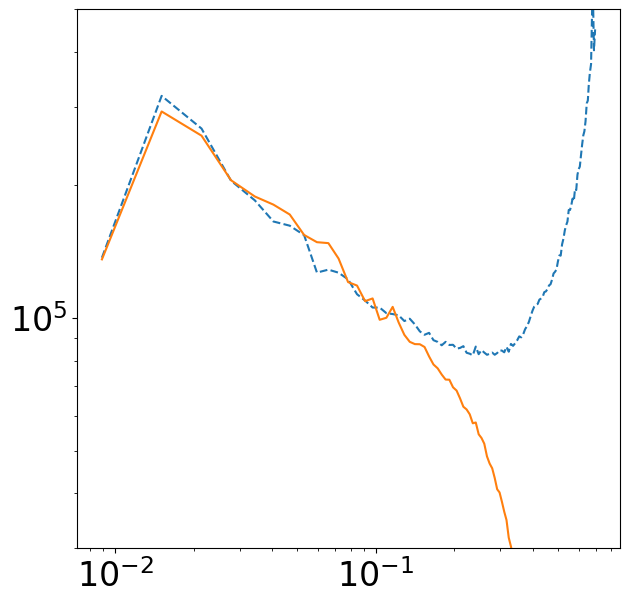

In [128]:
pl.figure()
pl.plot(k_truth, Pk0_truth, ls='--')
pl.plot(k_mock, Pk0_mock)
pl.xscale('log')
pl.yscale('log')
pl.ylim(3e4, 5e5)




In [62]:
# save_subvol_Nhalo.shape
# Nhalos = save_subvol_Nhalo.reshape(ns_h, ns_h, ns_h)
# M_halos = save_subvol_Mtot.reshape(ns_h, ns_h, ns_h, ndim_diff + 1)



In [93]:
# nb
# nax_h
# xarray.shape
# x_cy.shape
M_halos.shape, save_subvol_Nhalo.shape, save_subvol_Mtot.shape



((128, 128, 128, 10), (512, 16, 16, 16), (512, 16, 16, 16, 10))

In [102]:
Pk0_mock_all = []
for js in tqdm(range(save_subvol_Nhalo.shape[0])):
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000//nb, nax_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    for jx in range(save_subvol_Nhalo.shape[1]):
        for jy in range(save_subvol_Nhalo.shape[2]):
            for jz in range(save_subvol_Nhalo.shape[3]):
                    Nh_vox = int(save_subvol_Nhalo[js, jx, jy, jz])
                    if Nh_vox > 0:
                        # for jh in range(Nh_vox):
                        # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))                        
                        lgM_mock.append((save_subvol_Mtot[js,jx, jy, jz, :Nh_vox]))

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')
    
    indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    # print(len(indsel_Pk_mock))
    # define 3D density field
    delta_mock = np.zeros((nax_h,nax_h,nax_h), dtype=np.float32)

    # construct 3D density field
    MASL.MA(pos_h_mock[indsel_Pk_mock,...], delta_mock, BoxSize//nb, MAS, verbose=verbose)

    # at this point, delta contains the effective number of particles in each voxel
    # now compute overdensity and density constrast
    delta_mock /= np.mean(delta_mock, dtype=np.float64);  delta_mock -= 1.0

    import Pk_library as PKL
    axis=0
    threads=1
    # compute power spectrum
    Pk_mock = PKL.Pk(delta_mock, BoxSize//nb, axis, MAS, threads, verbose)
    k_mock_js       = Pk_mock.k3D
    Pk0_mock_js     = Pk_mock.Pk[:,0] #monopole
    Pk0_mock_all.append(Pk0_mock_js)


    
    


  3%|▎         | 13/512 [00:00<00:04, 120.78it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

  8%|▊         | 39/512 [00:00<00:03, 124.70it/s]

Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00

 13%|█▎        | 65/512 [00:00<00:03, 121.70it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 18%|█▊        | 91/512 [00:00<00:03, 119.85it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 23%|██▎       | 117/512 [00:00<00:03, 120.13it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 28%|██▊       | 143/512 [00:01<00:03, 120.63it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 33%|███▎      | 169/512 [00:01<00:02, 119.46it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 38%|███▊      | 193/512 [00:01<00:02, 117.48it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 42%|████▏     | 217/512 [00:01<00:02, 117.22it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 47%|████▋     | 242/512 [00:02<00:02, 119.11it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 52%|█████▏    | 266/512 [00:02<00:02, 118.15it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 57%|█████▋    | 291/512 [00:02<00:01, 119.54it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 62%|██████▏   | 315/512 [00:02<00:01, 118.37it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 67%|██████▋   | 341/512 [00:02<00:01, 119.50it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 71%|███████▏  | 366/512 [00:03<00:01, 119.31it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 76%|███████▌  | 390/512 [00:03<00:01, 118.32it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 81%|████████▏ | 416/512 [00:03<00:00, 120.19it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 84%|████████▍ | 429/512 [00:03<00:00, 118.90it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 89%|████████▊ | 454/512 [00:03<00:00, 120.41it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

 94%|█████████▍| 480/512 [00:04<00:00, 121.53it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

100%|██████████| 512/512 [00:04<00:00, 119.72it/s]


Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken = 0.000 seconds


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Using CIC mass assignment scheme
Time taken =

In [103]:
Pk0_mock_all_arr = np.vstack(Pk0_mock_all)
Pk0_mock_all_arr.shape



(512, 13)

In [104]:
# np.mean(Pk0_mock_all_arr, axis=0)
Pk0_mock_all_arr_finite = []
for js in tqdm(range(Pk0_mock_all_arr.shape[0])):
    if np.isnan(Pk0_mock_all_arr[js,:]).any():
        pass
    else:
        Pk0_mock_all_arr_finite.append(Pk0_mock_all_arr[js,:])
Pk0_mock_all_arr_finite = np.vstack(Pk0_mock_all_arr_finite)        



100%|██████████| 512/512 [00:00<00:00, 424739.65it/s]


In [105]:
# Pk0_mock_all_arr_finite.shape
np.mean(Pk0_mock_all_arr_finite, axis=0)



array([1.31159959e+05, 1.03143668e+05, 8.45203328e+04, 6.82661269e+04,
       5.20063539e+04, 3.58047052e+04, 1.99222518e+04, 9.08675970e+03,
       3.93896865e+03, 1.10488549e+03, 3.78412211e+02, 2.99649895e+01,
       1.61924382e-09])

(10000.0, 300000.0)

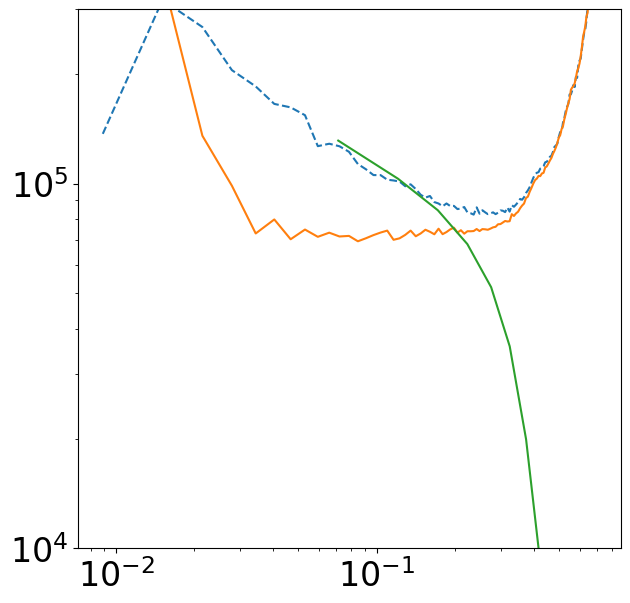

In [107]:
pl.figure()
pl.plot(k_truth, Pk0_truth, ls='--')
pl.plot(k_mock, Pk0_mock)
pl.plot(k_mock_js, np.mean(Pk0_mock_all_arr_finite, axis=0))
pl.xscale('log')
pl.yscale('log')
# pl.ylim(1e4, 3e5)
pl.ylim(1e4, 3e5)





In [99]:
Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test = model.inverse(
    cond_x=cond_tensor_test,
    cond_x_nsh=cond_tensor_nsh_test,
    use_truth_Nhalo=False,
    use_truth_M1=False,
    use_truth_Mdiff=False,
    mask_Mdiff_truth=mask_tensor_Mdiff_test,
    mask_M1_truth=mask_tensor_M1_test,
    Nhalos_truth=X_Nhalo_test,
    M1_truth=X_M1_test
    )



Text(0, 0.5, 'Histogram')

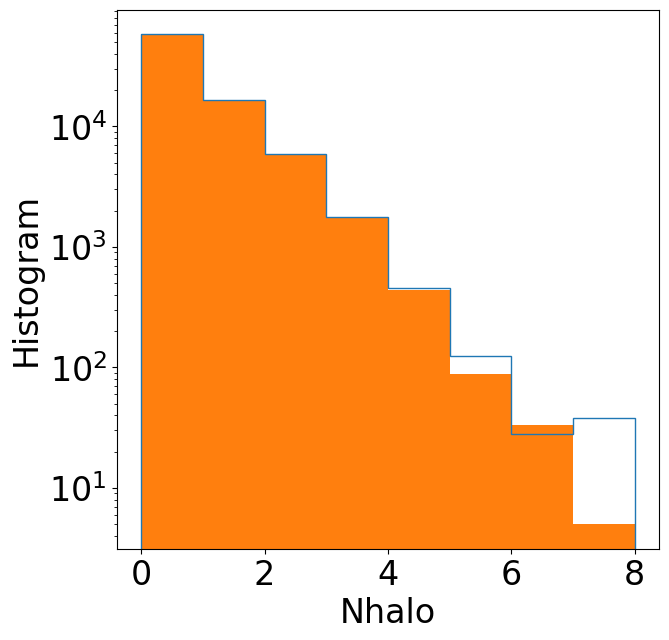

In [100]:
pl.figure()
indsel = np.where(cond_tensor_nsh_test.cpu().detach().numpy()[:,0] > 0.0)
_ = pl.hist(Ntot_samp_test[indsel], histtype='step', bins=[0,1,2,3,4,5,6,7,8])
_ = pl.hist(Nhalos_truth_tensor_test.cpu().detach().numpy()[indsel], bins=[0,1,2,3,4,5,6,7,8])

pl.yscale('log')
pl.xlabel('Nhalo')
pl.ylabel('Histogram')




Text(0, 0.5, 'Histogram')

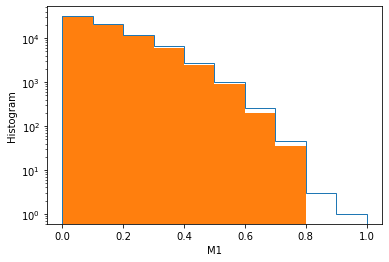

In [15]:
pl.figure()
indp = (mask_tensor_M1_samp_test.cpu().detach().numpy()[:,0] > 0)
_ = pl.hist(M1_samp_test.cpu().detach().numpy()[indp], range=(0,1), histtype='step')
indp = (mask_tensor_M1_test.cpu().detach().numpy() > 0)
_ = pl.hist(X_M1_test[:,0].cpu().detach().numpy()[indp], range=(0,1))
pl.yscale('log')
pl.xlabel('M1')
pl.ylabel('Histogram')




In [16]:
save_subvol_Nhalo = Ntot_samp_test.cpu().detach().numpy().reshape(nb**3, nax_h, nax_h, nax_h)
save_subvol_M1 = M1_samp_test.cpu().detach().numpy().reshape(nb**3, nax_h, nax_h, nax_h, np.newaxis)
save_subvol_Mdiff = M_diff_samp_test.cpu().detach().numpy().reshape(nb**3, nax_h, nax_h, nax_h, ndim_diff)
save_subvol_Mhalo = np.stack((save_subvol_M1, save_subvol_Mdiff), axis=4)
# create empty arrays for Nhalos and M_halos
Nhalos = np.zeros((ns_h, ns_h, ns_h))
M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

subvol_size = ns_h // nb

# iterate over subvolumes
jc = 0
for jx in range(nb):
    for jy in range(nb):
        for jz in range(nb):
            # update Nhalos and M_halos with subvolumes
            Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                   jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[jc]

            M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mhalo[jc]

            jc += 1
            
            
            

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'